In [24]:
# pip install --force-reinstall --upgrade git+https://github.com/SerjWeesp/AmarinML.git
from amarinml import *

In [1]:
import numpy as np
import pandas as pd
import copy
import os
import joblib
import ctypes
import gc
from probatus.feature_elimination import ShapRFECV
from skopt.space import Real, Integer
from skopt import BayesSearchCV
from catboost import CatBoostRegressor, Pool
from feature_engine.outliers import OutlierTrimmer
from feature_engine.encoding import RareLabelEncoder
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, RecursiveFeatureElimination
import shap
from probatus.utils import Scorer
from sklearn.metrics import mean_squared_error, make_scorer, mean_pinball_loss, mean_absolute_error, classification_report, confusion_matrix, median_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score

os.environ.pop("OPENBLAS_NUM_THREADS", None)  # None = ignore if not present
SEED = 23
pd.set_option('display.max_columns', None)

In [2]:
# tell Windows to stay awake
ctypes.windll.kernel32.SetThreadExecutionState(0x80000000 | 0x00000001)

-2147483648

In [3]:
class SinglePointTimeSeriesSplitByTicker:
    """
    Forward-expanding, single-point test per split (per ticker).
    For each ticker with N rows and n_splits = k, the test positions are:
    N-k, N-k+1, ..., N-1  (0-based within that ticker).
    """

    def __init__(self, n_splits=3):
        if n_splits < 1:
            raise ValueError(f"n_splits must be >= 1, got {n_splits}")
        self.n_splits = n_splits

    def split(self, X, y=None, groups=None):
        if not isinstance(X, pd.DataFrame):
            raise ValueError(
                "X must be a pandas DataFrame with 'Ticker' column")
        if 'Ticker' not in X.columns:
            raise ValueError("DataFrame must have a 'Ticker' column")

        # IMPORTANT: X must be sorted by time within each ticker BEFORE calling split.

        # Precompute positional indices (0..len(X)-1) for each ticker
        tickers = X['Ticker'].to_numpy()
        unique_tickers = pd.unique(tickers)
        ticker_to_pos = {t: np.where(tickers == t)[0] for t in unique_tickers}

        for i in range(self.n_splits):
            train_idx, test_idx = [], []

            for t, pos in ticker_to_pos.items():
                n = len(pos)
                # Need at least n_splits + 1 rows for this ticker
                if n <= self.n_splits:
                    continue

                # forward-expanding single test index (position within this ticker)
                test_pos_in_ticker = n - self.n_splits + i  # e.g., for n=10,k=3: 7,8,9
                test_idx.append(pos[test_pos_in_ticker])
                train_idx.extend(pos[:test_pos_in_ticker])

            if test_idx:
                gc.collect()
                yield np.array(train_idx), np.array(test_idx)

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

In [4]:
# --- Two tickers with different lengths: A=8, B=12 ---
df = pd.DataFrame({
    "Ticker": ["A"]*8 + ["B"]*12,
    "t": list(range(8)) + list(range(12))
})

cv = SinglePointTimeSeriesSplitByTicker(n_splits=2)
for k, (tr, te) in enumerate(cv.split(df), 1):
    print(f"Fold {k}:")
    print("  train idx:", tr.tolist())
    print("  test idx :", te.tolist())

Fold 1:
  train idx: [0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
  test idx : [6, 18]
Fold 2:
  train idx: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
  test idx : [7, 19]


In [5]:
df = pd.read_csv('D:\GitHub\sp500\sp500_diff.csv', low_memory=False)
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
df.replace([np.inf, -np.inf], 0, inplace=True)
df.sort_values(by=['Ticker', 'Date'], inplace=True)
df.drop(['Quarter_pct_diff_1', 'Quarter_pct_diff_4',
        'Fiscal year_pct_diff_1', 'Fiscal year_pct_diff_4', 'Fiscal year'], axis=1, inplace=True)
df['Quarter'] = df['Quarter'].astype('int64').astype('category')
print(df.shape)

(17445, 1134)


In [10]:
target = 'Future_Price_pct_diff_1'
df[target] = df.groupby('Ticker')['ClosePrice_pct_diff_1'].shift(-1)

predict_df = pd.DataFrame()
for ticker in df['Ticker'].unique():
    ticker_df = df[df['Ticker'] == ticker]
    max_date = ticker_df['Date'].max()
    last_row = ticker_df.loc[ticker_df['Date'] == max_date, :].copy()
    predict_df = pd.concat([predict_df, last_row], ignore_index=True)

df.dropna(inplace=True)
features = df.drop(columns=[target,  'Date'], axis=1).columns.tolist()
cat_features = df.drop(columns=[target, 'Date'], axis=1).select_dtypes(
    include=['object', 'category']).columns.tolist()
num_features = df.drop(columns=[target], axis=1).select_dtypes(
    include=['int64', 'float64']).columns.tolist()
print(
    f'Length of numerical features: {len(num_features)}, categorical: {len(cat_features)} , all features: {len(features)}')

Length of numerical features: 1129, categorical: 4 , all features: 1133


In [11]:
train_df = df.copy()
X_train = train_df[features]
y_train = train_df[target]

In [12]:
# Store average CV scores
medae_scores = []

# Try different delta values for Huber robustness
for delta in [0.5, 1.0, 2.0, 3.0]:
    # Define CatBoost with Huber loss
    model = CatBoostRegressor(
        iterations=100,
        learning_rate=0.1,
        depth=6,
        random_seed=SEED,
        loss_function=f'Huber:delta={delta}',
        eval_metric='RMSE',
        verbose=False,
        thread_count=-1,
        devices='0',
        task_type="GPU",
        data_partition='DocParallel',
        max_ctr_complexity=1,
        cat_features=cat_features,
        boosting_type='Plain',
        bootstrap_type="Bernoulli",
        subsample=0.7,
        border_count=128,
        early_stopping_rounds=50,
        allow_writing_files=False,
        grow_policy="SymmetricTree",
        gpu_ram_part=0.95,
    )

    # Time-series cross-validation
    tscv = SinglePointTimeSeriesSplitByTicker(n_splits=4)

    # Define Median Absolute Error scorer
    medae_scorer = make_scorer(median_absolute_error, greater_is_better=False)

    # Cross-validation with MedAE
    scores = cross_val_score(model, X_train, y_train,
                             cv=tscv, scoring=medae_scorer)
    print(f"Delta={delta}, Scores={scores}")
    medae_scores.append(scores.mean())

print("Average Median Absolute Error scores by delta:", medae_scores)

Delta=0.5, Scores=[-0.10627258 -0.09822146 -0.10195491 -0.08123995]
Delta=1.0, Scores=[-0.10551204 -0.09766863 -0.10375263 -0.08000084]
Delta=2.0, Scores=[-0.10640931 -0.09819447 -0.10098571 -0.07841599]
Delta=3.0, Scores=[-0.10566137 -0.09624311 -0.10415782 -0.08006767]
Average Median Absolute Error scores by delta: [-0.0969222235509674, -0.09673353621272256, -0.09600137079732336, -0.0965324933258575]


In [13]:
model = CatBoostRegressor(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    random_seed=SEED,
    loss_function=f'Huber:delta=2.0',
    eval_metric='RMSE',
    verbose=False,
    thread_count=-1,
    devices='0',
    task_type="GPU",
    data_partition='DocParallel',
    max_ctr_complexity=1,
    cat_features=cat_features,
    boosting_type='Plain',
    bootstrap_type="Bernoulli",
    subsample=0.7,
    border_count=128,
    early_stopping_rounds=50,
    allow_writing_files=False,
    grow_policy="SymmetricTree",
    gpu_ram_part=0.9,
)

In [14]:
model.fit(X_train, y_train, cat_features=cat_features, verbose=False)

# Retrieve feature importances
importances = model.get_feature_importance()

# Retrieve the corresponding feature names (if available)
feature_names = model.feature_names_

# Create a DataFrame with the feature names and their importances
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort the DataFrame in descending order by importance
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Print the top 30 important features
print(importance_df.head(30))

                                          feature  importance
178                                     MACD_Hist    6.801168
287                                       Quarter    4.075695
956                                RSI_pct_diff_4    3.987176
182                         Market Capitalization    3.809952
764                          MinVolume_pct_diff_4    2.846898
762                           MinPrice_pct_diff_4    2.671917
761                           MinPrice_pct_diff_1    2.598522
191                                      MinPrice    2.259605
763                          MinVolume_pct_diff_1    2.129388
993                            Revenue_pct_diff_1    1.821205
588  Foreign Exchange Rate Adjustments_pct_diff_4    1.788980
758                       MedianVolume_pct_diff_4    1.731967
97                                      FCF Yield    1.584361
757                       MedianVolume_pct_diff_1    1.415950
573                          FCF Yield_pct_diff_1    1.400935
463     

In [20]:
# wrap the sklearn scorer in a probatus Scorer (ShapRFECV requires probatus.utils.Scorer)
probatus_medae = Scorer("medae", custom_scorer=medae_scorer)

shap_selector = ShapRFECV(
    model=model,
    cv=tscv,
    step=0.1,
    scoring=probatus_medae,
    n_jobs=1,
    verbose=1,
    random_state=SEED)

shap_selector.fit(X_train, y_train, columns_to_keep=cat_features)

c:\Users\Dell\miniforge3\envs\gpu311\Lib\site-packages\probatus\utils\arrayfuncs.py:108: UserWarning: The following variables in X contains categorical variables: ['Ticker', 'Quarter', 'GICS Sector', 'GICS Sub-Industry']. Make sure to use a model that handles them automatically or encode them into numerical variables.
  warnings.warn(


Selected: 547 ['Ticker', 'Accounts Payable', 'Accounts Receivable', 'Accrued Expenses', 'Accrued Interest Payable', 'Accrued Interest Receivable', 'Acquisition of Real Estate Assets', 'Additional Paid-In Capital', 'Adjusted Funds From Operations (AFFO)', 'Advertising Expenses', 'Allowance for Borrowed Funds for Construction', 'Allowance for Equity Funds for Construction', 'Allowance for Loan Losses', 'Amortization of Goodwill & Intangibles', 'Asset Management Fee', 'Asset Turnover', 'Asset Writedown', 'Asset Writedown & Restructuring Costs', 'Basic Shares Outstanding', 'Book Value Per Share', 'Brokerage Commission', 'Buildings', 'Buyback Yield / Dilution', 'Capital Expenditures', 'Cash & Equivalents', 'Cash & Short-Term Investments', 'Cash Acquisition', 'Cash Acquisitions', 'Cash Growth', 'Cash Income Tax Paid', 'Cash Interest Paid', 'Change in Accounts Payable', 'Change in Accounts Receivable', 'Change in Income Taxes', 'Change in Inventory', 'Change in Unearned Revenue', 'Change in W

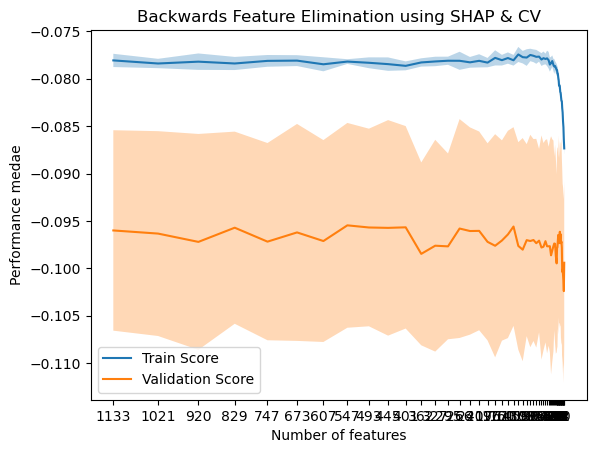

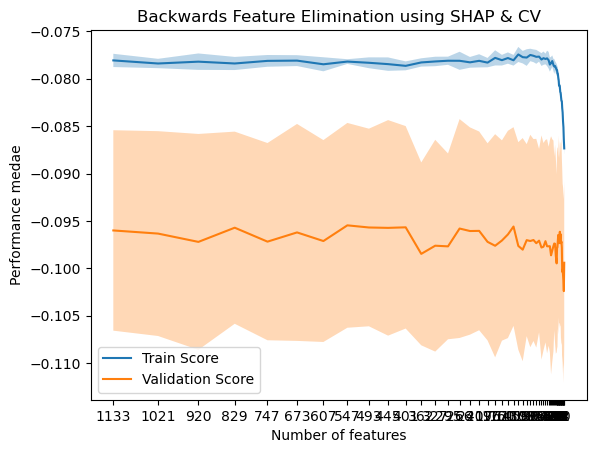

In [22]:
selected = shap_selector.get_reduced_features_set('best')
print("Selected:", len(selected), selected)
shap_selector.plot()

In [25]:
n_iter = 30

# Define search space
param_space = {
    'learning_rate': Real(0.02, 0.2, prior='log-uniform'),
    'depth': Integer(4, 8),
    'l2_leaf_reg': Real(1e-3, 5.0, prior='log-uniform'),
    'iterations': Integer(500, 3000),
    'random_strength': Real(1e-3, 2.0, prior='log-uniform'),
    'min_data_in_leaf': Integer(10, 200),
    'leaf_estimation_iterations': Integer(1, 8),
    'subsample': Real(0.6, 0.9),
}


# Initialize the progress bar with the number of iterations
callback = TqdmCallback(total=n_iter)

opt = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    n_iter=n_iter,
    cv=tscv,
    scoring=medae_scorer,
    n_jobs=1,
    n_points=1,
    random_state=SEED,
)

# Fit gs
opt.fit(X_train[selected], y_train, cat_features=cat_features,
        callback=callback, verbose=False)

# Retrieve the best model and results
best_model = opt.best_estimator_
results = opt.cv_results_
params = results['params']

# Best model and parameters
print("Best score:", opt.best_score_)
print("Best params:", opt.best_params_)

joblib.dump(best_model, 'sp500_best_catboost_model.pkl')

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [1:07:00<00:00, 207.09s/it]

Best score: -0.09537873048250682
Best params: OrderedDict([('depth', 8), ('iterations', 500), ('l2_leaf_reg', 4.999999999999999), ('leaf_estimation_iterations', 3), ('learning_rate', 0.020000000000000004), ('min_data_in_leaf', 193), ('random_strength', 0.001), ('subsample', 0.6)])


['sp500_best_catboost_model.pkl']

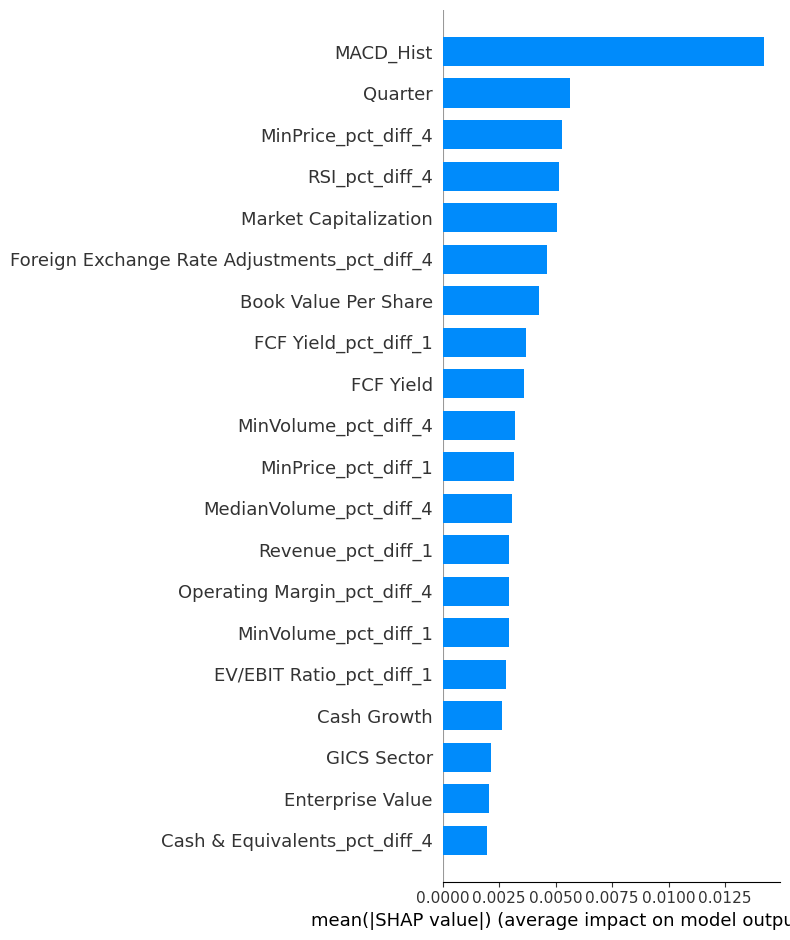

In [26]:
# Use the best model and the selected features
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train[selected])


shap.summary_plot(shap_values, X_train[selected], plot_type="bar")

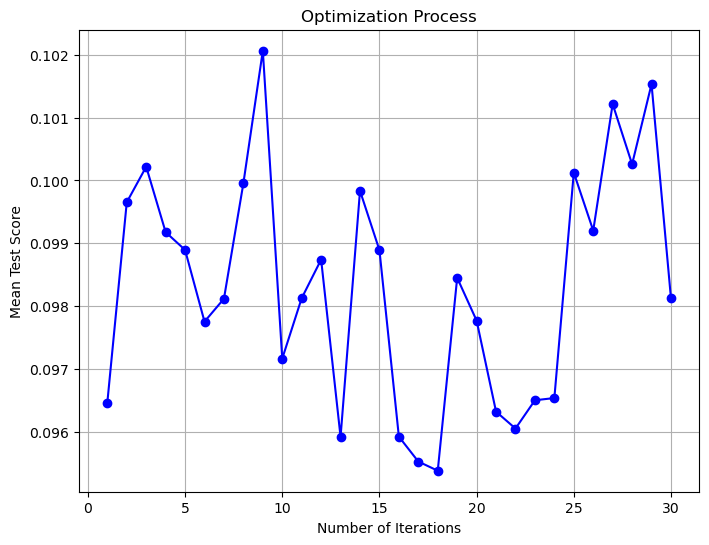

In [27]:
# Extract the results
results = pd.DataFrame(opt.cv_results_)
results['mean_test_score'] = -results['mean_test_score']

# Extract the mean test scores and number of iterations
iterations = np.arange(1, n_iter + 1)

# Plot the scores
plt.figure(figsize=(8, 6))
plt.plot(iterations, results['mean_test_score'],
         marker='o', linestyle='-', color='b')
plt.xlabel('Number of Iterations')
plt.ylabel('Mean Test Score')
plt.title('Optimization Process')
plt.grid(True)
plt.show()

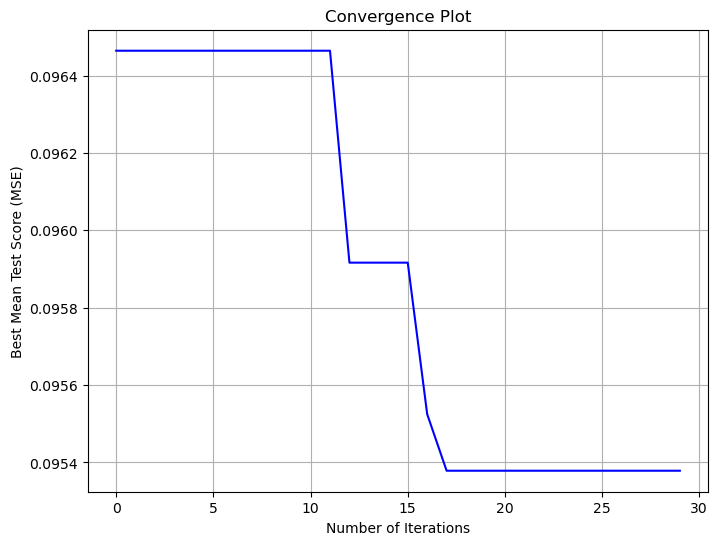

In [28]:
# Extract best scores at each iteration
best_scores = np.minimum.accumulate(results['mean_test_score'])

# Plot the convergence
plt.figure(figsize=(8, 6))
plt.plot(best_scores, linestyle='-', color='b')
plt.xlabel('Number of Iterations')
plt.ylabel('Best Mean Test Score (MSE)')
plt.title('Convergence Plot')
plt.grid(True)
plt.show()

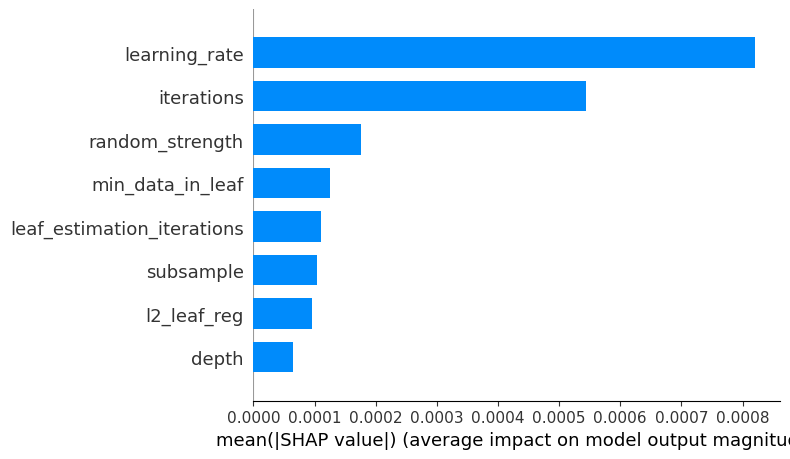

In [29]:

# Mean test scores are negative due to the scoring used
mean_test_scores = -results['mean_test_score']

# Create a DataFrame for analysis
hyperparams_df = pd.DataFrame(params)
hyperparams_df['mean_test_score'] = mean_test_scores

# If any hyperparameters are strings (e.g. loss_function), encode them
for col in hyperparams_df.drop('mean_test_score', axis=1).select_dtypes(include='object').columns:
    hyperparams_df[col] = hyperparams_df[col].astype('category').cat.codes

# Rebuild a fresh CatBoostRegressor with the best hyperparameters from search
best_params = opt.best_params_

# Fit a simple model to explain the hyperparameter importance
hyperparam_model = CatBoostRegressor(**best_params, verbose=0)

hyperparam_model.fit(
    hyperparams_df.drop('mean_test_score', axis=1),
    hyperparams_df['mean_test_score']
)

hyperparam_model.fit(hyperparams_df.drop(
    'mean_test_score', axis=1), hyperparams_df['mean_test_score'])


# Create a SHAP explainer
explainer = shap.Explainer(hyperparam_model)
shap_values = explainer(hyperparams_df.drop('mean_test_score', axis=1))

# Plot feature importance based on SHAP values
shap.summary_plot(shap_values, hyperparams_df.drop(
    'mean_test_score', axis=1), plot_type="bar")

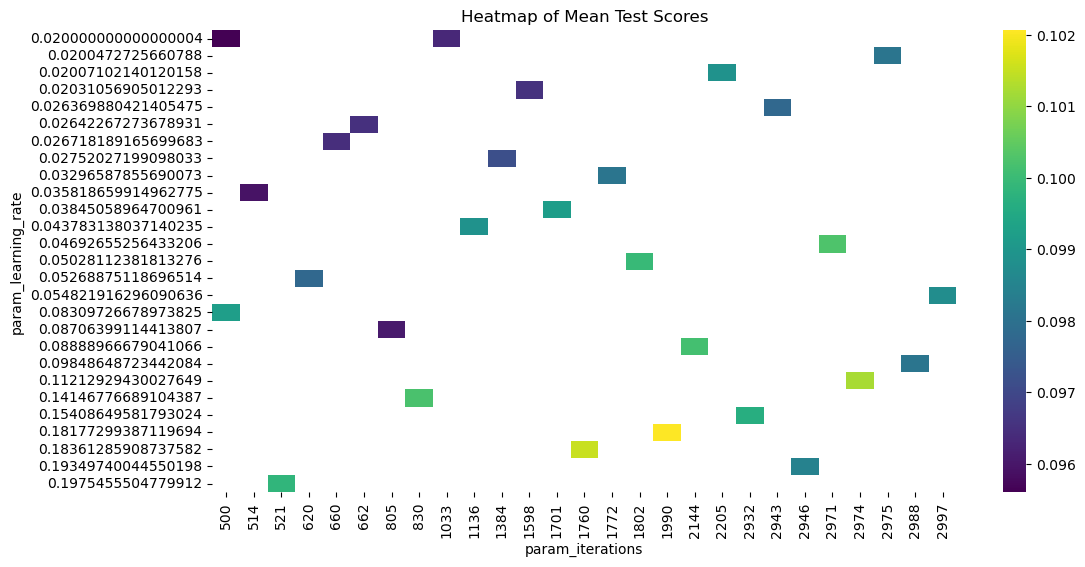

In [30]:
# Create a pivot table for the heatmap
pivot_table = pd.DataFrame(results).pivot_table(
    values='mean_test_score',
    index='param_learning_rate',
    columns='param_iterations',
    aggfunc='mean'
)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=False, fmt=".1f", cmap="viridis")
plt.title('Heatmap of Mean Test Scores')
plt.show()

In [31]:
best_model = joblib.load('sp500_best_catboost_model.pkl')

In [32]:
# Get the train/test indices for the last fold
splits = list(tscv.split(X_train, y_train))
train_idx, test_idx = splits[-1]   # last element

# Slice data
X_tr, y_tr = X_train.iloc[train_idx], y_train.iloc[train_idx]
X_te, y_te = X_train.iloc[test_idx], y_train.iloc[test_idx]

best_model.fit(X_tr[selected], y_tr)

# Predictions on the last fold test set
y_pred = model.predict(X_te)

preds_binary = [1 if i > 0 else 0 for i in y_pred]
test_binary = [1 if i > 0 else 0 for i in y_te]

print(confusion_matrix(test_binary, preds_binary))
print(classification_report(test_binary, preds_binary))

[[ 56 152]
 [ 30 258]]
              precision    recall  f1-score   support

           0       0.65      0.27      0.38       208
           1       0.63      0.90      0.74       288

    accuracy                           0.63       496
   macro avg       0.64      0.58      0.56       496
weighted avg       0.64      0.63      0.59       496



In [33]:
# Create a DataFrame to store actual, predicted, and errors
errors = np.abs(y_te - y_pred)
error_df = X_te[['Ticker']].copy()
error_df['Observed'] = y_te
error_df['Predicted'] = y_pred
error_df['Absolute Error'] = errors

# Sort by error in descending order and display the top 30
top_30_errors = error_df.sort_values(
    by='Absolute Error', ascending=False).head(30)

print('Median absolute error:', np.median(errors))
top_30_errors

Median absolute error: 0.07459363802981975


,Ticker,Observed,Predicted,Absolute Error
3541,COIN,1.035011,0.348141,0.686871
14621,STX,0.674412,0.099372,0.575040
11800,NRG,0.688952,0.140915,0.548038
2916,CEG,0.602941,0.089879,0.513062
11980,NVDA,0.563031,0.064423,0.498608
1704,AXON,0.574180,0.083196,0.490984
1380,APH,0.508230,0.063589,0.444641
13434,PWR,0.488012,0.069699,0.418313
13542,RCL,0.528538,0.115581,0.412957
16759,WDC,0.561003,0.158646,0.402356


In [34]:
# Sort by error in descending order and display the top 30
top_30_errors = error_df.sort_values(
    by='Predicted', ascending=False).head(30)

top_30_errors

,Ticker,Observed,Predicted,Absolute Error
3541,COIN,1.035011,0.348141,0.686871
12284,ON,0.679525,0.305710,0.373815
13002,PLTR,0.615166,0.287475,0.327691
16435,VST,0.652381,0.256088,0.396293
14259,SMCI,0.431367,0.213445,0.217922
4487,DECK,-0.078168,0.183392,0.261560
1164,ANET,0.320470,0.168914,0.151555
16759,WDC,0.561003,0.158646,0.402356
15123,TER,0.093108,0.149644,0.056536
4267,CZR,0.135600,0.144424,0.008825


In [35]:
preds = best_model.predict(predict_df[selected])
predict_next = pd.DataFrame([predict_df['Ticker'].unique(), preds*100]).T.rename(
    columns={0: 'Ticker', 1: 'Predicted price change pct'}).sort_values(by='Predicted price change pct',
                                                                        ascending=False)
predict_next.head(10)

,Ticker,Predicted price change pct
372,PLTR,19.908678
158,ENPH,14.760702
36,APA,13.156082
255,JKHY,11.594261
47,AXON,10.911044
8,ADI,10.666766
285,LRCX,10.472996
91,CLX,10.339761
376,PODD,10.1542
324,MTCH,10.092841


In [36]:
predict_next.tail(10).sort_values(by='Predicted price change pct',
                                  ascending=True)

,Ticker,Predicted price change pct
154,EL,-11.628183
119,CVS,-5.715379
437,TMO,-4.466098
457,ULTA,-4.221985
115,CTAS,-4.085819
177,FANG,-3.891981
286,LULU,-3.311644
227,HSIC,-3.262916
432,TER,-3.147969
147,EA,-2.90844


In [37]:
fin_features = ['Revenue', 'Net Income', 'EBIT Margin', 'Free Cash Flow Margin', 'Dividend Growth', \
                'Revenue_pct_diff_1', 'Net Income_pct_diff_1', 'EBIT Margin_pct_diff_1', 'Free Cash Flow Margin_pct_diff_1', 'Dividend Growth_pct_diff_1', \
                'Revenue_pct_diff_4', 'Net Income_pct_diff_4', 'EBIT Margin_pct_diff_4', 'Free Cash Flow Margin_pct_diff_4', 'Dividend Growth_pct_diff_4']
df.loc[df['Ticker']=='NVDA', fin_features].iloc[-4:]

,Revenue,Net Income,EBIT Margin,Free Cash Flow Margin,Dividend Growth,Revenue_pct_diff_1,Net Income_pct_diff_1,EBIT Margin_pct_diff_1,Free Cash Flow Margin_pct_diff_1,Dividend Growth_pct_diff_1,Revenue_pct_diff_4,Net Income_pct_diff_4,EBIT Margin_pct_diff_4,Free Cash Flow Margin_pct_diff_4,Dividend Growth_pct_diff_4
11977,30040.0,16599.0,0.6206,0.4498,1.5,0.153433,0.115449,-0.044054,-0.217739,0.0,1.224032,1.682016,0.232817,0.002675,0.0
11978,35082.0,19309.0,0.6234,0.4793,1.5,0.167843,0.163263,0.004512,0.065585,0.0,0.936093,1.089040,0.084362,0.231184,0.0
11979,39331.0,22091.0,0.6111,0.3954,1.5,0.121116,0.144078,-0.019731,-0.175047,0.0,0.779442,0.798209,-0.007793,-0.222877,0.0
11980,44062.0,18775.0,0.4911,0.5943,1.5,0.120287,-0.150106,-0.196367,0.503035,0.0,0.691829,0.261676,-0.243530,0.033565,0.0


In [38]:
# restore normal sleep behavior
ctypes.windll.kernel32.SetThreadExecutionState(0x80000000)

-2147483647

In [39]:
def gains_test(df, model, tscv, top_n=3):
    cv = tscv
    splits = list(cv.split(df))
    gains_df = pd.DataFrame()
    for i in range(-8, -4):
        train_idx, test_idx = splits[i]

        X_tr = df.iloc[train_idx][features]
        y_tr = df.iloc[train_idx][target]
        X_te = df.iloc[test_idx]
        model.fit(X_tr, y_tr, cat_features=cat_features, verbose=False)
        preds = model.predict(X_te[features])

        pred_df = pd.DataFrame({
            'Ticker': df.iloc[test_idx]['Ticker'].values,
            'Predicted price change pct': preds 
        }).sort_values(by='Predicted price change pct', ascending=False)

        to_buy = pred_df['Ticker'].head(top_n)
        
        for t in to_buy:
            buy_1q = X_te[X_te['Ticker'] == t][['Ticker', 'Date', target]].copy()
            buy_1q['Period'] = i
            buy_1q['Future_Price_pct_diff_4'] = df.loc[df['Ticker']==t, "ClosePrice_pct_diff_4"].iloc[i+4]
            gains_df = pd.concat([gains_df, buy_1q], ignore_index=True)
    
    return gains_df

In [42]:
cv = SinglePointTimeSeriesSplitByTicker(n_splits=8)
gains_df = gains_test(df, model, cv, top_n=5)
gains_df

,Ticker,Date,Future_Price_pct_diff_1,Period,Future_Price_pct_diff_4
0,PLTR,2023-06-30,0.043705,-8,0.652316
1,NVDA,2023-07-30,-0.133618,-8,1.419120
2,SMCI,2023-06-30,0.100181,-8,2.287262
3,FFIV,2023-06-30,0.101737,-8,0.177561
4,MHK,2023-07-01,-0.168185,-8,0.101105
5,GNRC,2023-09-30,0.186123,-7,0.458150
6,BAX,2023-09-30,0.032604,-7,0.038127
7,NVDA,2023-10-29,0.507071,-7,2.495872
8,MHK,2023-09-30,0.206153,-7,0.850717
9,FSLR,2023-09-30,0.066155,-7,0.543660


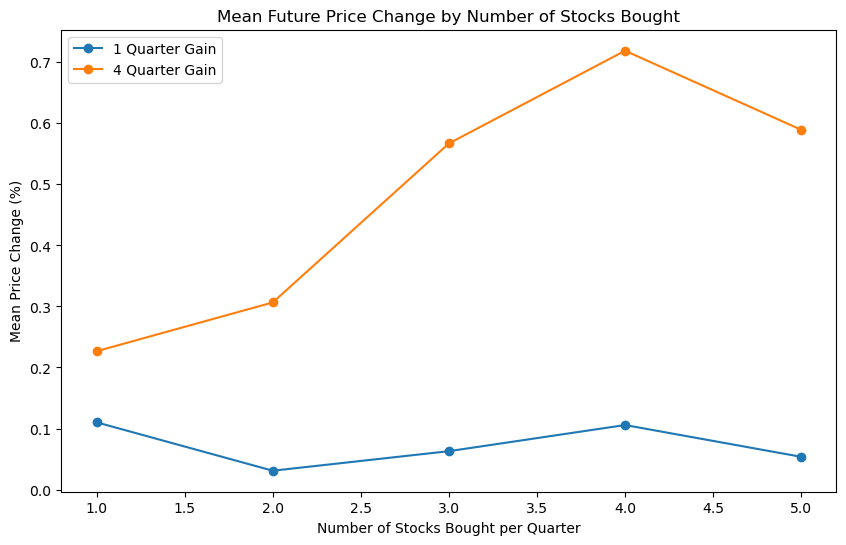

In [41]:
gains_1q = []
gains_4q = []
for n in range(1,6):
    gains_df = gains_test(df, model, cv, top_n=n)
    gains_1q.append(gains_df['Future_Price_pct_diff_1'].mean())
    gains_4q.append(gains_df['Future_Price_pct_diff_4'].mean())

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1,6), gains_1q, marker='o', label='1 Quarter Gain')
ax.plot(range(1,6), gains_4q, marker='o', label='4 Quarter Gain')
ax.set_xlabel('Number of Stocks Bought per Quarter')
ax.set_ylabel('Mean Price Change (%)')
ax.legend()
plt.title('Mean Future Price Change by Number of Stocks Bought')
plt.show()  